In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import matplotlib as mpl
import os
import catboost as cb
from collections import Counter

from IPython.core.pylabtools import figsize
from scipy import stats

from sklearn.model_selection import train_test_split


In [2]:
#Getting Working Directory
os.getcwd()

#Setting style and font size for graphs
sns.set_style("whitegrid")
mpl.rcParams['font.size'] = 13

In [3]:
#load original data into dataframe
file ='D:\\Abhishek\\Personal\\Springboard\\music_recom\\train_final.csv'

df = pd.read_csv(file)
df.shape

(7377418, 73)

In [4]:
drop_col = ['msno','song_id','genre_ids_encoded', 'composer_encoded', 
            'artist_name_encoded', 'lyricist_encoded', 'isrc_country_encoded']
df.drop(drop_col, axis=1, inplace = True)

# Converting to categories
cat_names = list(df.select_dtypes(include='object').columns)
df[cat_names] = df[cat_names].astype('category')

# Converting int64 to int32 type
int32 = ['count_artist_played', 'count_song_played']
df[int32] = df[int32].astype('int32')

int8 = ['language','bd','city', 'genre_count', 'lyricist_count','composer_count','artist_count','registered_via']
df[int8] = df[int8].astype('int8')

# Converting int64 to int16 type
int64 = list(df.select_dtypes(include='int64').columns)
df[int64] = df[int64].astype('int16')

# Converting float64 to float32 and float16 type
float_names = list(df.select_dtypes(include='float64').columns)
float_names.remove('song_length')
df[float_names] = df[float_names].astype('float16')
df['song_length'] = df['song_length'].astype('float32')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7377418 entries, 0 to 7377417
Data columns (total 66 columns):
source_system_tab      category
source_screen_name     category
source_type            category
target                 int16
song_length            float32
genre_ids              category
artist_name            category
composer               category
lyricist               category
language               int8
city                   int8
bd                     int8
registered_via         int8
lyricist_count         int8
artist_count           int8
composer_count         int8
genre_count            int8
isrc_country           category
isrc_year              int16
song_freq              int16
artist_freq            int16
count_song_played      int32
count_artist_played    int32
duration               int16
registration_year      int16
expiration_year        int16
expiration_month       int16
age_of_song            int16
song_type              category
us_1                   fl

In [5]:
# Separating Numeric and Non_numeric Data
cat_names = ['source_system_tab', 'source_screen_name','source_type', 'song_type']

categorical = df.drop(df.columns.difference(cat_names),axis = 1)
numeric = df.drop(cat_names, axis = 1)


#Creating Dummy variables for Categorical Data using One Hot Encoding
dummies = pd.get_dummies(categorical,drop_first = True)


In [6]:
X = pd.concat([numeric,dummies],axis=1).drop('target', axis = 1)
y = df.target
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7377418 entries, 0 to 7377417
Columns: 102 entries, song_length to song_type_short
dtypes: category(5), float16(37), float32(1), int16(8), int32(2), int8(8), uint8(41)
memory usage: 1.1 GB


In [7]:
#Identifying index of Categorical data
cat_index = [1,2,3,4, 13]
z = X.columns
cat_columns = list(z[cat_index])
cat_columns

['genre_ids', 'artist_name', 'composer', 'lyricist', 'isrc_country']

In [8]:
# Finding numeric_col for normalization
numeric_col = numeric.drop(cat_columns,axis = 1)
numeric_col = numeric_col.drop('target', axis = 1).columns

numeric_col

Index(['song_length', 'language', 'city', 'bd', 'registered_via',
       'lyricist_count', 'artist_count', 'composer_count', 'genre_count',
       'isrc_year', 'song_freq', 'artist_freq', 'count_song_played',
       'count_artist_played', 'duration', 'registration_year',
       'expiration_year', 'expiration_month', 'age_of_song', 'us_1', 'us_2',
       'us_3', 'us_4', 'us_5', 'us_6', 'us_7', 'us_8', 'us_9', 'us_10',
       'us_11', 'us_12', 'us_13', 'us_14', 'us_15', 'us_16', 'us_17', 'us_18',
       'us_19', 'us_20', 'ug_1', 'ug_2', 'ug_3', 'ug_4', 'ug_5', 'ua_1',
       'ua_2', 'ua_3', 'ua_4', 'ua_5', 'ua_6', 'ua_7', 'ua_8', 'ua_9', 'ua_10',
       'ua_11', 'ua_12'],
      dtype='object')

In [9]:
#Creating our Feature and Target Data Set: X, y respectively
X = pd.concat([numeric,dummies],axis=1).drop('target', axis = 1)
y = df.target

#Splitting Data into Training and Test Data Set
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 42)

In [10]:
X_train.shape

(3688709, 102)

In [11]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3688709 entries, 288797 to 6413414
Columns: 102 entries, song_length to song_type_short
dtypes: category(5), float16(37), float32(1), int16(8), int32(2), int8(8), uint8(41)
memory usage: 618.3 MB


There are two types of error, False Positive and False Negative. Predicting that a song will not be listened again but actually song gets listened again. This is false negative. Predicting that a song will be listened again but in actually song is not listened again is called false positive. For us both type of error are important

## Normalization

In [12]:
# data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler

# Copy of Data set
X_train_norm = X_train.copy()
X_test_norm = X_test.copy()

for i in numeric_col:
    
    # fit on training data column
    scale = MinMaxScaler().fit(X_train_norm[[i]])
    
    # transform the training data column
    X_train_norm[i] = scale.transform(X_train_norm[[i]])
    
    # transform the testing data column
    X_test_norm[i] = scale.transform(X_test_norm[[i]])


In [13]:
float_names = list(X_train_norm.select_dtypes(include='float64').columns)
X_train_norm[float_names] = X_train_norm[float_names].astype('float16')
X_test_norm[float_names] = X_test_norm[float_names].astype('float16')

float_names = list(X_train_norm.select_dtypes(include='float32').columns)
X_train_norm[float_names] = X_train_norm[float_names].astype('float16')
X_test_norm[float_names] = X_test_norm[float_names].astype('float16')

### CatBoost Classifier

In [14]:
# Base Line Evaluation
from sklearn.metrics import classification_report, balanced_accuracy_score, plot_roc_curve
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.metrics import plot_confusion_matrix, precision_recall_fscore_support,log_loss
class_names = ['Not Learning', 'Learning']

In [15]:
def auc_curve(y_test,y_pred_test,auc_test):
    fpr,tpr, threshold = roc_curve(y_test, y_pred_test)
    _ = plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.4f)' %auc_test )
    _ = plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    _ = plt.xlim([0.0, 1.0])
    _ = plt.ylim([0.0, 1.05])
    _ = plt.xlabel('False Positive Rate')
    _ = plt.ylabel('True Positive Rate')
    _ = plt.title('Receiver operating characteristic example')
    _ = plt.legend(loc="lower right")


In [16]:
cb_clf = cb.CatBoostClassifier(random_state = 42, one_hot_max_size = 40, thread_count = 4)
cb_clf.fit(X_train_norm, y_train, cat_features= cat_index)

Learning rate set to 0.34355
0:	learn: 0.6586784	total: 4.49s	remaining: 1h 14m 50s
1:	learn: 0.6401433	total: 8.7s	remaining: 1h 12m 22s
2:	learn: 0.6301366	total: 13.5s	remaining: 1h 14m 31s
3:	learn: 0.6247462	total: 19.4s	remaining: 1h 20m 32s
4:	learn: 0.6211189	total: 23.6s	remaining: 1h 18m 21s
5:	learn: 0.6182254	total: 27.9s	remaining: 1h 17m 6s
6:	learn: 0.6153088	total: 31.6s	remaining: 1h 14m 38s
7:	learn: 0.6132550	total: 34.9s	remaining: 1h 12m 13s
8:	learn: 0.6114084	total: 38.3s	remaining: 1h 10m 17s
9:	learn: 0.6090529	total: 41.9s	remaining: 1h 9m 10s
10:	learn: 0.6077986	total: 45.4s	remaining: 1h 7m 58s
11:	learn: 0.6065622	total: 48.7s	remaining: 1h 6m 45s
12:	learn: 0.6052264	total: 52.5s	remaining: 1h 6m 28s
13:	learn: 0.6034753	total: 56.3s	remaining: 1h 6m 3s
14:	learn: 0.6024379	total: 60s	remaining: 1h 5m 39s
15:	learn: 0.6015526	total: 1m 3s	remaining: 1h 5m 10s
16:	learn: 0.6003088	total: 1m 7s	remaining: 1h 4m 39s
17:	learn: 0.5995934	total: 1m 10s	remaini

151:	learn: 0.5642576	total: 8m 51s	remaining: 49m 26s
152:	learn: 0.5641776	total: 8m 55s	remaining: 49m 22s
153:	learn: 0.5640024	total: 8m 58s	remaining: 49m 20s
154:	learn: 0.5638534	total: 9m 2s	remaining: 49m 16s
155:	learn: 0.5637056	total: 9m 5s	remaining: 49m 11s
156:	learn: 0.5635532	total: 9m 9s	remaining: 49m 9s
157:	learn: 0.5634549	total: 9m 12s	remaining: 49m 5s
158:	learn: 0.5633435	total: 9m 15s	remaining: 48m 56s
159:	learn: 0.5632629	total: 9m 18s	remaining: 48m 53s
160:	learn: 0.5631514	total: 9m 22s	remaining: 48m 49s
161:	learn: 0.5630137	total: 9m 25s	remaining: 48m 46s
162:	learn: 0.5627417	total: 9m 29s	remaining: 48m 44s
163:	learn: 0.5625947	total: 9m 33s	remaining: 48m 41s
164:	learn: 0.5625008	total: 9m 36s	remaining: 48m 37s
165:	learn: 0.5624092	total: 9m 39s	remaining: 48m 33s
166:	learn: 0.5623328	total: 9m 43s	remaining: 48m 30s
167:	learn: 0.5622360	total: 9m 46s	remaining: 48m 26s
168:	learn: 0.5621254	total: 9m 49s	remaining: 48m 19s
169:	learn: 0.5

299:	learn: 0.5500524	total: 17m 10s	remaining: 40m 3s
300:	learn: 0.5499803	total: 17m 13s	remaining: 39m 59s
301:	learn: 0.5498918	total: 17m 17s	remaining: 39m 57s
302:	learn: 0.5498413	total: 17m 20s	remaining: 39m 54s
303:	learn: 0.5498080	total: 17m 23s	remaining: 39m 49s
304:	learn: 0.5497434	total: 17m 27s	remaining: 39m 45s
305:	learn: 0.5496814	total: 17m 29s	remaining: 39m 41s
306:	learn: 0.5495671	total: 17m 33s	remaining: 39m 37s
307:	learn: 0.5495049	total: 17m 36s	remaining: 39m 34s
308:	learn: 0.5494679	total: 17m 40s	remaining: 39m 30s
309:	learn: 0.5494117	total: 17m 43s	remaining: 39m 27s
310:	learn: 0.5493311	total: 17m 47s	remaining: 39m 23s
311:	learn: 0.5492842	total: 17m 50s	remaining: 39m 20s
312:	learn: 0.5492363	total: 17m 54s	remaining: 39m 17s
313:	learn: 0.5491534	total: 17m 57s	remaining: 39m 13s
314:	learn: 0.5491252	total: 18m 1s	remaining: 39m 10s
315:	learn: 0.5490596	total: 18m 5s	remaining: 39m 8s
316:	learn: 0.5490296	total: 18m 8s	remaining: 39m 5

447:	learn: 0.5412771	total: 26m 2s	remaining: 32m 5s
448:	learn: 0.5412462	total: 26m 6s	remaining: 32m 1s
449:	learn: 0.5412062	total: 26m 9s	remaining: 31m 58s
450:	learn: 0.5411619	total: 26m 13s	remaining: 31m 54s
451:	learn: 0.5411243	total: 26m 16s	remaining: 31m 50s
452:	learn: 0.5410470	total: 26m 19s	remaining: 31m 47s
453:	learn: 0.5410159	total: 26m 22s	remaining: 31m 43s
454:	learn: 0.5409743	total: 26m 26s	remaining: 31m 39s
455:	learn: 0.5409162	total: 26m 29s	remaining: 31m 35s
456:	learn: 0.5408633	total: 26m 32s	remaining: 31m 31s
457:	learn: 0.5408213	total: 26m 35s	remaining: 31m 28s
458:	learn: 0.5407657	total: 26m 39s	remaining: 31m 25s
459:	learn: 0.5407090	total: 26m 42s	remaining: 31m 21s
460:	learn: 0.5406580	total: 26m 45s	remaining: 31m 17s
461:	learn: 0.5406063	total: 26m 48s	remaining: 31m 13s
462:	learn: 0.5405563	total: 26m 51s	remaining: 31m 9s
463:	learn: 0.5404836	total: 26m 55s	remaining: 31m 5s
464:	learn: 0.5404377	total: 26m 58s	remaining: 31m 2s


595:	learn: 0.5346658	total: 34m 38s	remaining: 23m 29s
596:	learn: 0.5346249	total: 34m 42s	remaining: 23m 25s
597:	learn: 0.5345908	total: 34m 46s	remaining: 23m 22s
598:	learn: 0.5345364	total: 34m 50s	remaining: 23m 19s
599:	learn: 0.5344910	total: 34m 54s	remaining: 23m 16s
600:	learn: 0.5344535	total: 34m 59s	remaining: 23m 13s
601:	learn: 0.5344267	total: 35m 2s	remaining: 23m 10s
602:	learn: 0.5343821	total: 35m 6s	remaining: 23m 6s
603:	learn: 0.5343375	total: 35m 9s	remaining: 23m 3s
604:	learn: 0.5343004	total: 35m 13s	remaining: 22m 59s
605:	learn: 0.5342728	total: 35m 17s	remaining: 22m 56s
606:	learn: 0.5342314	total: 35m 21s	remaining: 22m 53s
607:	learn: 0.5342107	total: 35m 25s	remaining: 22m 50s
608:	learn: 0.5341452	total: 35m 30s	remaining: 22m 47s
609:	learn: 0.5340956	total: 35m 34s	remaining: 22m 44s
610:	learn: 0.5340648	total: 35m 38s	remaining: 22m 41s
611:	learn: 0.5340350	total: 35m 42s	remaining: 22m 38s
612:	learn: 0.5339970	total: 35m 46s	remaining: 22m 3

743:	learn: 0.5295542	total: 44m 32s	remaining: 15m 19s
744:	learn: 0.5295303	total: 44m 36s	remaining: 15m 15s
745:	learn: 0.5295162	total: 44m 39s	remaining: 15m 12s
746:	learn: 0.5294889	total: 44m 43s	remaining: 15m 8s
747:	learn: 0.5294641	total: 44m 47s	remaining: 15m 5s
748:	learn: 0.5294150	total: 44m 50s	remaining: 15m 1s
749:	learn: 0.5293796	total: 44m 54s	remaining: 14m 58s
750:	learn: 0.5293405	total: 44m 58s	remaining: 14m 54s
751:	learn: 0.5292911	total: 45m 2s	remaining: 14m 51s
752:	learn: 0.5292592	total: 45m 6s	remaining: 14m 47s
753:	learn: 0.5292378	total: 45m 10s	remaining: 14m 44s
754:	learn: 0.5292036	total: 45m 14s	remaining: 14m 40s
755:	learn: 0.5291784	total: 45m 17s	remaining: 14m 37s
756:	learn: 0.5291500	total: 45m 21s	remaining: 14m 33s
757:	learn: 0.5291271	total: 45m 25s	remaining: 14m 30s
758:	learn: 0.5291055	total: 45m 28s	remaining: 14m 26s
759:	learn: 0.5290778	total: 45m 32s	remaining: 14m 22s
760:	learn: 0.5290439	total: 45m 36s	remaining: 14m 1

892:	learn: 0.5251374	total: 54m 12s	remaining: 6m 29s
893:	learn: 0.5251149	total: 54m 16s	remaining: 6m 26s
894:	learn: 0.5251013	total: 54m 20s	remaining: 6m 22s
895:	learn: 0.5250694	total: 54m 24s	remaining: 6m 18s
896:	learn: 0.5250411	total: 54m 28s	remaining: 6m 15s
897:	learn: 0.5250233	total: 54m 32s	remaining: 6m 11s
898:	learn: 0.5249981	total: 54m 36s	remaining: 6m 8s
899:	learn: 0.5249778	total: 54m 40s	remaining: 6m 4s
900:	learn: 0.5249522	total: 54m 44s	remaining: 6m
901:	learn: 0.5249191	total: 54m 48s	remaining: 5m 57s
902:	learn: 0.5248814	total: 54m 52s	remaining: 5m 53s
903:	learn: 0.5248549	total: 54m 56s	remaining: 5m 50s
904:	learn: 0.5248220	total: 54m 59s	remaining: 5m 46s
905:	learn: 0.5247775	total: 55m 4s	remaining: 5m 42s
906:	learn: 0.5247515	total: 55m 8s	remaining: 5m 39s
907:	learn: 0.5247058	total: 55m 12s	remaining: 5m 35s
908:	learn: 0.5246809	total: 55m 16s	remaining: 5m 31s
909:	learn: 0.5246678	total: 55m 19s	remaining: 5m 28s
910:	learn: 0.5246

In [17]:
cb_clf.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'Logloss',
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'],
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'fold_permutation_block': 0,
 'leaf_estimation_method': 'Newton',
 'counter_calc_method': 'SkipTest',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'ctr_leaf_count_limit': 18446744073709551615,
 'bayesian_matrix_reg': 0.10000000149011612,
 'one_hot_max_size': 40,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': False,
 'max_ctr_complexity': 4,
 'model_size_reg': 0.5,
 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:CtrBord

Training accuracy: 0.7596
Test accuracy    : 0.7366
Training AUC Score: 0.8412
Testing AUC Score: 0.8149
Classification Report - Training
              precision    recall  f1-score   support

           0       0.76      0.76      0.76   1830920
           1       0.76      0.76      0.76   1857789

    accuracy                           0.76   3688709
   macro avg       0.76      0.76      0.76   3688709
weighted avg       0.76      0.76      0.76   3688709

Classification Report - Testing
              precision    recall  f1-score   support

Not Learning       0.73      0.74      0.73   1831842
    Learning       0.74      0.74      0.74   1856867

    accuracy                           0.74   3688709
   macro avg       0.74      0.74      0.74   3688709
weighted avg       0.74      0.74      0.74   3688709



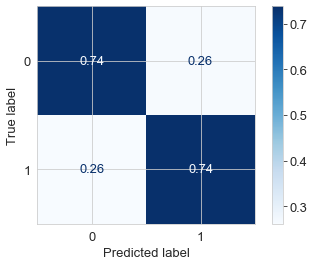

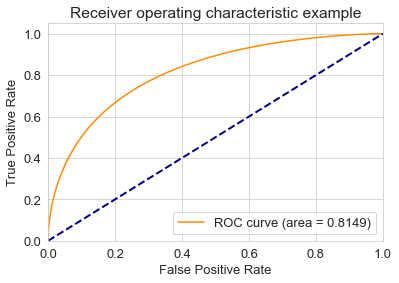

In [18]:
# Base Line Evaluation

#Predicting for testing and trainig data sets
y_test_proba = cb_clf.predict_proba(X_test_norm)[:,1]
y_train_proba = cb_clf.predict_proba(X_train_norm)[:,1]

y_pred_test = cb_clf.predict(X_test_norm)
y_pred_train = cb_clf.predict(X_train_norm)

    #Accuracy Score
print("Training accuracy: %0.4f" %cb_clf.score(X_train_norm, y_train))
print("Test accuracy    : %0.4f" %cb_clf.score(X_test_norm, y_test))
#print("Test log loss    : %0.4f" %log_loss(y_train, lr.predict_proba(X_train)))
#AUC Score
auc_train = roc_auc_score(y_train,y_train_proba)
auc_test = roc_auc_score(y_test,y_test_proba)

print('Training AUC Score: %0.4f' %auc_train)  
print('Testing AUC Score: %0.4f' %auc_test)          

print('Classification Report - Training')
print(classification_report(y_train,y_pred_train))

print('Classification Report - Testing')
print(classification_report(y_test,y_pred_test,target_names = class_names))

plot_confusion_matrix(cb_clf, X_test_norm, y_test,  cmap=plt.cm.Blues, normalize = 'true') #display_labels=class_names,
plt.show()
auc_curve(y_test,y_test_proba,auc_test)


In [19]:
#coefficients = xg.feature_importances_
coefficients = cb_clf.feature_importances_
coef = pd.DataFrame(coefficients, index = X_train_norm.columns, columns = ['Feature Importance'])
coef.sort_values('Feature Importance', ascending = False, inplace = True)
print("Top 5:")
print(coef[:11])



Top 5:
                                        Feature Importance
count_song_played                                11.121768
ug_1                                              7.720955
us_1                                              5.369432
source_system_tab_my library                      3.421270
language                                          3.222950
artist_name                                       3.071420
source_screen_name_Local playlist more            2.884552
count_artist_played                               2.853216
us_3                                              2.766137
ua_1                                              2.372643
source_type_local-library                         2.038195


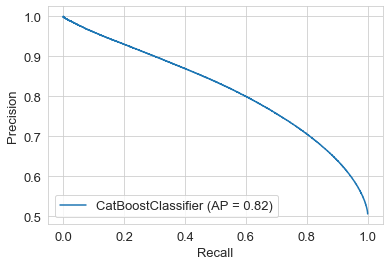

In [20]:
from sklearn.metrics import plot_precision_recall_curve
plot_precision_recall_curve(cb_clf, X_test_norm, y_test)

## Predicting on Testing data set provided by WSDM

In [42]:
#load original data into dataframe
file2 ='D:\\Abhishek\\Personal\\Springboard\\music_recom\\test_final.csv'

df_test = pd.read_csv(file2)
df_test.shape

(2556790, 73)

In [43]:
ids = df_test.id
drop_col = ['id','msno','song_id','genre_ids_encoded', 'composer_encoded', 
            'artist_name_encoded', 'lyricist_encoded', 'isrc_country_encoded']
df_test.drop(drop_col, axis=1, inplace = True)

# Converting to categories
cat_names = list(df_test.select_dtypes(include='object').columns)
df_test[cat_names] = df_test[cat_names].astype('category')

# Converting int64 to int32 type
int32 = ['count_artist_played', 'count_song_played']
df_test[int32] = df_test[int32].astype('int32')

int8 = ['language','bd','city', 'genre_count', 'lyricist_count','composer_count','artist_count','registered_via']
df_test[int8] = df_test[int8].astype('int8')

# Converting int64 to int16 type
int64 = list(df_test.select_dtypes(include='int64').columns)
df_test[int64] = df_test[int64].astype('int16')

# Converting float64 to float32 and float16 type
float_names = list(df_test.select_dtypes(include='float64').columns)
float_names.remove('song_length')
df_test[float_names] = df_test[float_names].astype('float16')
df_test['song_length'] = df_test['song_length'].astype('float32')

df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2556790 entries, 0 to 2556789
Data columns (total 65 columns):
source_system_tab      category
source_screen_name     category
source_type            category
song_length            float32
genre_ids              category
artist_name            category
composer               category
lyricist               category
language               int8
city                   int8
bd                     int8
registered_via         int8
lyricist_count         int8
artist_count           int8
composer_count         int8
genre_count            int8
isrc_country           category
isrc_year              int16
song_freq              int16
artist_freq            int16
count_song_played      int32
count_artist_played    int32
duration               int16
registration_year      int16
expiration_year        int16
expiration_month       int16
age_of_song            int16
song_type              category
us_1                   float16
us_2                   

In [44]:
# Separating Numeric and Non_numeric Data
cat_names = ['source_system_tab', 'source_screen_name','source_type', 'song_type']

categorical = df_test.drop(df_test.columns.difference(cat_names),axis = 1)
numeric = df_test.drop(cat_names, axis = 1)


#Creating Dummy variables for Categorical Data using One Hot Encoding
dummies = pd.get_dummies(categorical,drop_first = True)

In [45]:
X_valid = pd.concat([numeric,dummies],axis=1)

In [46]:
#Identifying index of Categorical data
cat_index = [1,2,3,4, 13]
z = X.columns
cat_columns = list(z[cat_index])
cat_columns

['genre_ids', 'artist_name', 'composer', 'lyricist', 'isrc_country']

In [47]:
# Finding numeric_col for normalization
numeric_col = numeric.drop(cat_columns,axis = 1).columns
numeric_col

Index(['song_length', 'language', 'city', 'bd', 'registered_via',
       'lyricist_count', 'artist_count', 'composer_count', 'genre_count',
       'isrc_year', 'song_freq', 'artist_freq', 'count_song_played',
       'count_artist_played', 'duration', 'registration_year',
       'expiration_year', 'expiration_month', 'age_of_song', 'us_1', 'us_2',
       'us_3', 'us_4', 'us_5', 'us_6', 'us_7', 'us_8', 'us_9', 'us_10',
       'us_11', 'us_12', 'us_13', 'us_14', 'us_15', 'us_16', 'us_17', 'us_18',
       'us_19', 'us_20', 'ug_1', 'ug_2', 'ug_3', 'ug_4', 'ug_5', 'ua_1',
       'ua_2', 'ua_3', 'ua_4', 'ua_5', 'ua_6', 'ua_7', 'ua_8', 'ua_9', 'ua_10',
       'ua_11', 'ua_12'],
      dtype='object')

In [48]:
# Copy of Data set
X_valid_norm = X_valid.copy()

for i in numeric_col:
    
    # fit on training data column
    scale = MinMaxScaler().fit(X_valid_norm[[i]])
    
    # transform the training data column
    X_valid_norm[i] = scale.transform(X_valid_norm[[i]])
    
    

In [49]:
float_names = list(X_train_norm.select_dtypes(include='float64').columns)
X_valid_norm[float_names] = X_train_norm[float_names].astype('float16')

float_names = list(X_train_norm.select_dtypes(include='float32').columns)
X_valid_norm[float_names] = X_train_norm[float_names].astype('float16')

In [50]:
y_valid_pred_test = cb_clf.predict(X_valid_norm)

In [51]:
subm = pd.DataFrame()
subm['id'] = ids
subm['target'] = y_valid_pred_test
subm.to_csv('D:\\Abhishek\\Personal\\Springboard\\music_recom\\valid_final.csv', index=False)